In [36]:
import torch
import os
import pickle as pkl
import numpy as np
import torchvision
import itertools
import matplotlib.pyplot as plt
from certificate_methods import *
from utils import ReducedModel, parse
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import cv2
import glob

In [37]:
import torch

print(torch.__version__)
print(torchvision.__version__)

1.10.1+cu102
0.11.2+cu102


In [38]:


def scale_batch_images_(batch, min_val=0, max_val=1):
    """
    Scales a batch of PyTorch tensors (images) to the specified range [min_val, max_val].

    Args:
        batch (torch.Tensor): A batch of PyTorch tensors (images) to be scaled with shape (batch_size, channels, height, width)
        min_val (float, optional): Minimum value of the target range. Defaults to 0.
        max_val (float, optional): Maximum value of the target range. Defaults to 1.

    Returns:
        torch.Tensor: A new batch of PyTorch tensors with values scaled to the specified range
    """

    batch_min = torch.amin(batch, dim=(1, 2, 3), keepdim=True)
    batch_max = torch.amax(batch, dim=(1, 2, 3), keepdim=True)

    # Normalize the batch of images to [0, 1] range
    normalized_batch = (batch - batch_min) / (batch_max - batch_min)

    # Scale the normalized batch to the target range [min_val, max_val]
    scaled_batch = normalized_batch * (max_val - min_val) + min_val

    return scaled_batch

def man_transform(masked_imgs):
    transformed_images = []
    for img in masked_imgs:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, -1, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, -1, 1, 1)
        timg = torch.tensor(img).unsqueeze(0)  # Add an extra dimension to make it a batch of size 1
    

        normalized_image = (timg/torch.max(timg)- mean) / std
        normalized_image = normalized_image [0]
    

        transformed_images.append(normalized_image)
    stacked_images = torch.stack(transformed_images, dim=0)
    return stacked_images

# Example usage:
# Assuming 'input_batch' is a PyTorch tensor of shape (batch_size, channels, height, width)
# scaled_batch = scale_batch_images(input_batch, 0, 1)
def evaluate(model, images, labels):
    with torch.no_grad():
        outputs = model(images)
        output_probs = torch.nn.Softmax(dim = 1)(outputs).detach().cpu().numpy()
    output_labels = np.argmax(output_probs, axis = 1)
    correct = np.sum(output_labels == labels.numpy())
    total = len(labels)
    print(f" Accuracy: {correct}/{total}: {correct / total}")
def prediction_probs(model, input_data):
    prob_dicts = []
    with torch.no_grad():
        outputs = model(input_data.cuda())
        output_probs = torch.nn.Softmax(dim = 1)(outputs).detach().cpu().numpy()
        print(output_probs.shape)

    output_labels = np.argmax(output_probs, axis = 1)
    for it in output_labels:
        prob_dicts.append({it: output_probs[0][it]})
        
    return prob_dicts

## Load model

In [39]:
model = torchvision.models.resnet50(pretrained=True).cuda()
model = torchvision.models.efficientnet_b7(pretrained=True).cuda()
#model.load_state_dict(torch.utils.model_zoo.load_url('https://download.pytorch.org/models/resnet50-19c8e357.pth'))
model.eval()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
model_2 = torchvision.models.efficientnet_b6(pretrained=True).cuda()
model_2.eval()
model_3 = torchvision.models.efficientnet_b5(pretrained=True).cuda()
model_3.eval()

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivatio

In [40]:
def name_class(class_dict):
    name_cls = {}
    for k, v in class_dict.items():
        name_cls[v[0]] = (int(k), v[1])
    return name_cls

import json

# Open the JSON file and read its contents
with open("/home/abka03/IML/soundness_saliency/name_class.json", "r") as f:
    json_data = f.read()

# Parse the JSON data into a dictionary
data_dict = json.loads(json_data)
print(data_dict)
class_dict = name_class(data_dict)
print(class_dict)

{'0': ['n01440764', 'tench'], '1': ['n01443537', 'goldfish'], '2': ['n01484850', 'great_white_shark'], '3': ['n01491361', 'tiger_shark'], '4': ['n01494475', 'hammerhead'], '5': ['n01496331', 'electric_ray'], '6': ['n01498041', 'stingray'], '7': ['n01514668', 'cock'], '8': ['n01514859', 'hen'], '9': ['n01518878', 'ostrich'], '10': ['n01530575', 'brambling'], '11': ['n01531178', 'goldfinch'], '12': ['n01532829', 'house_finch'], '13': ['n01534433', 'junco'], '14': ['n01537544', 'indigo_bunting'], '15': ['n01558993', 'robin'], '16': ['n01560419', 'bulbul'], '17': ['n01580077', 'jay'], '18': ['n01582220', 'magpie'], '19': ['n01592084', 'chickadee'], '20': ['n01601694', 'water_ouzel'], '21': ['n01608432', 'kite'], '22': ['n01614925', 'bald_eagle'], '23': ['n01616318', 'vulture'], '24': ['n01622779', 'great_grey_owl'], '25': ['n01629819', 'European_fire_salamander'], '26': ['n01630670', 'common_newt'], '27': ['n01631663', 'eft'], '28': ['n01632458', 'spotted_salamander'], '29': ['n01632777', 

In [54]:
##
from PIL import Image
output_dir = "/mnt/sda/abka03-data/KI/explantions/"
image_path = "/mnt/sda/abka03-data/imagenet/imagewoof2-320/val"
jpg_files = []
for root, dirs, files in os.walk(image_path):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".JPEG"):
            jpg_files.append(os.path.join(root, file))

select_sampe = 677 #589

image = Image.open(jpg_files[select_sampe]) 

image = Image.open("/mnt/sda/abka03-data/imagenet/imagewoof2-320/val/n02086240/n02086240_451.JPEG")

class_num, class_name  = class_dict[jpg_files[select_sampe].split("/")[-2]]

print(class_num)
image = image.resize((224, 224))
plt.imshow(image)
plt.axis("off")
plt.title(f"{class_name}:{class_num}")
plt.show()

input_tensor = transform(image).unsqueeze(0)
print(input_tensor.shape)


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/sda/abka03-data/imagenet/imagewoof2-320/val/n02086240/n02086240_451.JPEG'

## load sample images and labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Accuracy: 0/1: 0.0
(1, 1000)
The output and the probability of them:  [{204: 0.62940395}]


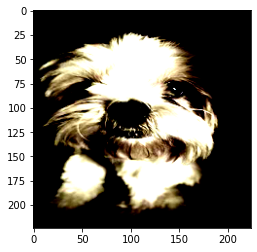

In [53]:
input_image = input_tensor.cuda() #+ torch.normal(.5, 0.16, size=input_tensor.shape).cuda()
#input_image = torch.rand(size=input_tensor.shape).cuda()
plt.imshow(input_image[0].permute(1, 2, 0).cpu().numpy())
#all_images = scale_batch_images(all_images)
label = torch.tensor([class_num])
#input_images = man_transform(all_images).cuda()
evaluate(model, input_image, label)
probdict = prediction_probs(model, input_image)
print("The output and the probability of them: ", probdict)


## Noise base. It is the baseline for removing feature

In [51]:
noise_images = torch.from_numpy(np.load('./noise_images.npy'))
print("Number of noise image: " , len(noise_images))
# Use grey:
#noise_images = None
#print(noise_images.shape)

Number of noise image:  100


In [44]:

def gen_exp(input_):
    K = 1
    scale = 4
    lr = 0.5
    steps = 2
    obj = 'xent'
    noise_bs = 10
    reg_l1 = 2e-05
    reg_tv = 0.01
    reg_ent = 0.0
    debug = True

    with torch.no_grad():
        outputs = model(input_.cuda())
        output_probs = torch.nn.Softmax(dim = 1)(outputs).detach().cpu().numpy()
    #Force explnation
    output_labels = np.argmax(output_probs, axis = 1)
    #output_labels = [100]
    probs = torch.zeros(input_.shape[0], 1000)
    for target_label in output_labels:
        probs[:, target_label] = 1

    batch_masked_model = learn_masks_for_batch_Kcert(
                    model, input_, target_probs=probs, K=K, scale=scale,
                    opt=optim.Adam, lr=lr, steps=steps, obj=obj,
                    noise_mean=None, noise_batch=noise_images, noise_bs=noise_bs,
                    reg_l1=reg_l1, reg_tv=reg_tv, reg_ent=reg_ent, old_mask=None, debug=debug)
    masks = batch_masked_model.mask().detach().cpu()
    heatmap = masks[0]
    return heatmap, batch_masked_model
    


In [55]:
i = 0
for pt in jpg_files:
    if i > 100:
        break
    xp_path = os.path.join (*pt.split("/")[5:-1])
    name = pt.split("/")[-1].split(".")[0]
    save_path = os.path.join(output_dir, xp_path)
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    exp_path = os.path.join(save_path, name)
    image = Image.open(pt).convert('RGB') 
    #class_num, class_name  = class_dict[jpg_files[select_sampe].split("/")[-2]]
    image = image.resize((224, 224))
    input_tensor = transform(image).unsqueeze(0)
    heat_map, mod = gen_exp(input_tensor)
    torch.save(heat_map, f'{exp_path}.pt')
    print(exp_path)
    
    i+=1
    
    
    

    
   
    

1 4 0.5 200 xent 10 2e-05 0.01 0.0
199: loss: 6.40, l1 norm: 7546, tv: 13.32, ent: 0.17, pred prob: 0.7950
/mnt/sda/abka03-data/KI/explantions/imagewoof2-320/val/n02086240/n02086240_10642
1 4 0.5 200 xent 10 2e-05 0.01 0.0
0: loss: 6.90, l1 norm: 24610, tv: 88.80, ent: 0.68, pred prob: 0.5146

In [ ]:
exp_files = []
for root, dirs, files in os.walk(os.path.join(output_dir,"imagewoof2-320/val")):
    for file in files:
        if file.endswith(".pt") or file.endswith(".npy"):
            exp_files.append(os.path.join(root, file))
print(exp_files)

['/mnt/sda/abka03-data/KI/explantions/imagewoof2-320/val/n02086240/n02086240_10642.pt', '/mnt/sda/abka03-data/KI/explantions/imagewoof2-320/val/n02086240/n02086240_872.pt', '/mnt/sda/abka03-data/KI/explantions/imagewoof2-320/val/n02086240/n02086240_13101.pt', '/mnt/sda/abka03-data/KI/explantions/imagewoof2-320/val/n02086240/n02086240_630.pt', '/mnt/sda/abka03-data/KI/explantions/imagewoof2-320/val/n02086240/n02086240_11860.pt', '/mnt/sda/abka03-data/KI/explantions/imagewoof2-320/val/n02086240/n02086240_9540.pt']


In [ ]:
def apply_masks_to_images(images_list, masks_list):
    """
    Applies individual single-channel masks to a list of channel-first 3-channel images.

    Args:
        images_list (list of np.array): A list of channel-first 3-channel images, each with shape (3, height, width)
        masks_list (list of np.array): A list of single-channel masks, each with shape (height, width)

    Returns:
        list of np.array: A list of masked channel-first images, each with shape (3, height, width)
    """

    if len(images_list) != len(masks_list):
        raise ValueError("The number of images and masks must be equal")

    masked_images = []

    for image, mask in zip(images_list, masks_list):
        if len(image.shape) != 3 or image.shape[0] != 3:
            raise ValueError("Each input image must have a shape of (3, height, width)")

        if len(mask.shape) != 3:
            raise ValueError("Each input mask must have a shape of (channel, height, width)")

        # Expand the mask to match the shape of the image
        s_mask = mask[0]
        expanded_mask = expanded_mask = s_mask.unsqueeze(0).repeat(3, 1, 1)
        # Multiply the image with the expanded mask
        masked_image = image * expanded_mask

        # Add the masked image to the list
        masked_images.append(masked_image)
    masked_images = torch.stack(masked_images, axis=0)
    return masked_images

In [ ]:
j = 0 
input_dir = "/mnt/sda/abka03-data/imagenet/"
for exp in exp_files:
    if j > 0:
        break
    im_path = os.path.join(*exp.split("/")[6:-1])

    name = exp.split("/")[-1].split(".")[0]
    final_impath = f"{os.path.join(input_dir, im_path, name)}.JPEG"
    print(final_impath)
    image = Image.open(final_impath)
    #exp_path = os.path.join(save_path, name)
    #class_num, class_name  = class_dict[jpg_files[select_sampe].split("/")[-2]]
    image = image.resize((224, 224))
    input_tensor = transform(image).unsqueeze(0)
    explan = torch.load(exp)
    masked_img = apply_masks_to_images(input_tensor, explan)
    org_prediction = prediction_probs(model,input_tensor)
    ground_truth_cls = class_dict[exp.split("/")[-2]]
    print(ground_truth_cls[0] == list(org_prediction[0].keys())[0])
    print(ground_truth_cls)
    print(org_prediction)
    predict = prediction_probs(model,masked_img)
    predict_2 = prediction_probs(model_2,masked_img)
    predict_3 = prediction_probs(model_3,masked_img)
    print("Absolut size of heatmap: ", torch.sum(explan)/ (224*224))
    print(predict)
    print(predict_2)
    print(predict_3)



/mnt/sda/abka03-data/imagenet/imagewoof2-320/val/n02086240/n02086240_10642.JPEG
(1, 1000)
True
(155, 'Shih-Tzu')
[{155: 0.92219293}]
(1, 1000)
(1, 1000)
(1, 1000)
Absolut size of heatmap:  tensor(0.1638)
[{155: 0.9197658}]
[{154: 0.5420718}]
[{155: 0.9095819}]
/mnt/sda/abka03-data/imagenet/imagewoof2-320/val/n02086240/n02086240_872.JPEG
(1, 1000)
True
(155, 'Shih-Tzu')
[{155: 0.9438208}]
(1, 1000)
(1, 1000)
(1, 1000)
Absolut size of heatmap:  tensor(0.3003)
[{155: 0.9502056}]
[{155: 0.83953416}]
[{155: 0.9372358}]
/mnt/sda/abka03-data/imagenet/imagewoof2-320/val/n02086240/n02086240_13101.JPEG
(1, 1000)
True
(155, 'Shih-Tzu')
[{155: 0.8745068}]
(1, 1000)
(1, 1000)
(1, 1000)
Absolut size of heatmap:  tensor(0.1565)
[{155: 0.9632063}]
[{155: 0.9029928}]
[{155: 0.956849}]
/mnt/sda/abka03-data/imagenet/imagewoof2-320/val/n02086240/n02086240_630.JPEG
(1, 1000)
True
(155, 'Shih-Tzu')
[{155: 0.8552653}]
(1, 1000)
(1, 1000)
(1, 1000)
Absolut size of heatmap:  tensor(0.2557)
[{155: 0.958141}]
[{

In [ ]:


def apply_masks_to_images(images_list, masks_list):
    """
    Applies individual single-channel masks to a list of channel-first 3-channel images.

    Args:
        images_list (list of np.array): A list of channel-first 3-channel images, each with shape (3, height, width)
        masks_list (list of np.array): A list of single-channel masks, each with shape (height, width)

    Returns:
        list of np.array: A list of masked channel-first images, each with shape (3, height, width)
    """

    if len(images_list) != len(masks_list):
        raise ValueError("The number of images and masks must be equal")

    masked_images = []

    for image, mask in zip(images_list, masks_list):
        if len(image.shape) != 3 or image.shape[0] != 3:
            raise ValueError("Each input image must have a shape of (3, height, width)")

        if len(mask.shape) != 3:
            raise ValueError("Each input mask must have a shape of (channel, height, width)")

        # Expand the mask to match the shape of the image
        s_mask = mask[0]
        expanded_mask = expanded_mask = s_mask.unsqueeze(0).repeat(3, 1, 1)
        # Multiply the image with the expanded mask
        masked_image = image * expanded_mask

        # Add the masked image to the list
        masked_images.append(masked_image)
    masked_images = torch.stack(masked_images, axis=0)
    return masked_images
#plt.imshow(neg_heatmap[0][0])
print(heatmap.shape)
masked_image = apply_masks_to_images(input_image, heatmap.cuda())

masked_image_vis = scale_batch_images(masked_image)


plt.imshow(masked_image[0].permute(1, 2, 0).cpu().numpy())
image = transforms.ToPILImage()(masked_image_vis[0])

# Save the PIL image to a file
image.save("image.jpeg")

NameError: name 'heatmap' is not defined

In [ ]:
print("Masked images shape: ",masked_image.shape)
print("Masked image max, min: ", torch.max(masked_image), torch.min(masked_image))
masked_input = masked_image.clone().detach().cuda()
acc = evaluate(model,masked_image, label)
probdict = prediction_probs(model,masked_image)
print("The output and the probability of them: ", probdict)
plt.imshow(masked_image_vis[0].permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.title(f"{data_dict[str(list(probdict[0].keys())[0])][1]}:{list(probdict[0].values())[0]}")
plt.show()

In [ ]:
masked_input = masked_image.clone().detach().cuda()
acc = evaluate(model_2,masked_image, label)
probdict = prediction_probs(model_2,masked_image)
print("The output and the probability of them: ", probdict)

In [ ]:
masked_input = masked_image.clone().detach().cuda()
acc = evaluate(model_3,masked_image, label)
probdict = prediction_probs(model_3,masked_image)
print("The output and the probability of them: ", probdict)

Masked images shape:  torch.Size([1, 3, 224, 224])
Masked image max, min:  tensor(0.1331) tensor(0.)
 Accuracy: 1/1: 1.0
The output and the probability of them:  [{782: 0.99647576}]